In [1]:
import logic.pulsed.pulse_objects as po
from logic.pulsed.sampling_functions import SamplingFunctions as SF
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
pjl = pulsedjupyterlogic_AWG #Make sure the Logic is started in the Qudi manager!!!!
import pickle
import datetime
from logic import gwyfile as gwy
import numpy as np

###### Measurement parameters

In [2]:
#measurement parameters
pi_pulse = 75e-9

#Driving information for the first LO (SMBV)
target_freq_0 = 4.56479e9 #initial resonance frequency
LO_freq_0 = target_freq_0 + 100e6
power_0 = -1

#Driving information for the second LO (SGS)
target_freq_1 = 3e9
LO_freq_1 = target_freq_1 + 100e6
power_1 = -100#-20.7

#Information for running tracking mode
mw_start = 4.545e9
mw_stop = 4.585e9
mw_step = 1e6

max_sweeps_podmr =150e3 #Number of sweeps for tracking pulsed measurements
max_sweeps_T2 =150e3 #Number of sweeps for T2 related pulsed measurements

#Information for running the Hahn Echo measurement
tau_start = 200e-9
tau_stop = 30e-6
tau_num = 300

#Scan area
scan_start_z=0
scan_stop_z=1e-6
scan_step_z=50

lift_off_check_period = 60 #Define period, where the lift off is checked again

retract = True

#additional information for save tag
tip_name = 'A-H12-13'
sample = 'NbSe2_S4_rot'
temperature = '2.0K'
b_field = '70mT_Bnv_sFC'
contact = 'Z_lift_off'
extra = 'Set_E'

afm_scanner_logic.jupyter_meas_stop = False
afm_scanner_logic.jupyter_meas_pause = False

###### Helper functions

In [3]:
def prepare_AWG_sequence_mode(pi_pulse,init_res_freq, mw_start, mw_stop, mw_step, power, tau_start, tau_stop, tau_num):
    
    ensemble_list = []
    tau_arr_list = []
    alternating_list = []
    freq_sweep_list = []
    
    pjl.initialize_ensemble(pi_pulse=pi_pulse, LO_freq_0=init_res_freq + 100e6, target_freq_0=init_res_freq, power_0=power, printing = False, upload = False, set_up_measurement = False)
    AWG_ensemble_list, AWG_sequence_step_list, PS_seq_name, tau_arr, alternating, freq_sweep = pjl.PODMR(mw_start, mw_stop, mw_step)
    ensemble_list.append(AWG_ensemble_list[0])
    tau_arr_list.append(tau_arr)
    alternating_list.append(alternating)
    freq_sweep_list.append(freq_sweep)

    pjl.initialize_ensemble(pi_pulse=pi_pulse, LO_freq_0=init_res_freq + 100e6, target_freq_0=init_res_freq, power_0=power, printing = False, upload = False, set_up_measurement = False)
    AWG_ensemble_list, AWG_sequence_step_list, PS_seq_name, tau_arr, alternating, freq_sweep =pjl.Hecho_alt_phased(tau_start, tau_stop, tau_num)
    ensemble_list.append(AWG_ensemble_list[0])
    tau_arr_list.append(tau_arr)
    alternating_list.append(alternating)
    freq_sweep_list.append(freq_sweep)
    
    explicit_steps_list = []
    for idx, name in enumerate(ensemble_list):
        explicit_steps_list.append({"step_index" : idx,
                    "step_segment" : name,
                    "step_loops" : 1,
                    "next_step_index" : idx,
                    "step_end_cond" : 'always'
                    })
    
    sequence_step_list = explicit_steps_list
    pjl.AWG_MW_reset()
    pjl.AWG.load_ready_sequence_mode(sequence_step_list)

    return ensemble_list, tau_arr_list, alternating_list, freq_sweep_list, sequence_step_list

def run_measurement(idx, AWG_ensemble_name, tau_arr, alternating, freq_sweep, res_freq, power, max_sweeps, lift_off_height = 0, lift_off_check_period = 0, change_freq = True):
    #Setup measurement
    tau_num = len(tau_arr) * 2 if alternating else len(tau_arr)
    pjl.pulsed_master_AWG.set_fast_counter_settings(record_length=pjl.read_out_time, number_of_gates=tau_num)
    pjl.pulsed_master_AWG.set_measurement_settings(invoke_settings=False, 
                                controlled_variable=tau_arr,
                                number_of_lasers=tau_num, 
                                laser_ignore_list=[], 
                                alternating=alternating, 
                                units=('Hz' if freq_sweep else 's', 'arb. u.'))
    pjl.pulsed_master_AWG.pulsedmeasurementlogic().alternative_data_type = 'None'
    pjl.AWG.instance.set_sequence_start_step(idx)
        
    if change_freq:
        pjl.pulsed_master_AWG.set_ext_microwave_settings(use_ext_microwave=True, 
                                                frequency=res_freq + 100e6,
                                                power=power)
    
    pulsedmeasurementlogic_AWG._PulsedMeasurementLogic__elapsed_sweeps = 0
    
    #Lift off
    lift_off_start = 0
    if lift_off_height > 0:
        do_lift_off(lift_off_height)
        lift_off_start = time.time()
    
    #Start measuremenet
    pjl.start_measurement(measurement_type=AWG_ensemble_name, tip_name=tip_name, sample=sample, 
                          temperature=temperature, b_field=b_field, contact=contact+f'{lift_off_height}', extra=extra, printing = False)

    while True:
        if abs(lift_off_start-time.time())>=lift_off_check_period and lift_off_height > 0 and lift_off_check_period > 0:
            pulsedmeasurementlogic_AWG.pause_pulsed_measurement()
            go_into_contact()
            do_lift_off(lift_off_height)
            lift_off_start = time.time()
            pulsedmeasurementlogic_AWG.continue_pulsed_measurement()
            
        if pulsedmasterlogic_AWG.elapsed_sweeps>max_sweeps:
            pulsedmeasurementlogic_AWG.stop_pulsed_measurement()
            if lift_off_height > 0:
                go_into_contact()
            pulsedmeasurement_AWG.save_clicked() #Save measurement in qudi data file
            result = afm_scanner_logic.analyse_pulsed_meas(pulsedmasterlogic_AWG.analysis_settings, pulsedmeasurementlogic_AWG.laser_data, alternating)
            if alternating:
                return pulsedmeasurementlogic_AWG.signal_data[1], pulsedmeasurementlogic_AWG.signal_data[2], pulsedmeasurementlogic_AWG.signal_data[1] - pulsedmeasurementlogic_AWG.signal_data[2], np.mean(result[0][2])/result[0][3]
            else:
                return pulsedmeasurementlogic_AWG.signal_data[1], np.mean(result[2])/result[3]
        else:
            time.sleep(0.001)

def tracking_analysis(pulsed_ret0, slope2_podmr, prev):
    visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
    new_res_freq =  prev - visibility/slope2_podmr

    return new_res_freq, visibility

def PODMR_analysis(data, var_list, mode ='gaussian_dip'):
    try:
        if mode == 'double':
            fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)

        elif mode == 'N15':
            fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)

        elif mode == 'N14':
            fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)

        elif mode == 'gaussian_dip':
            fit = afm_scanner_logic._fitlogic.make_gaussian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
        res_freq = fit.params['center'].value
    except:
        res_freq = var_list[np.argmin(data)]
    
    return res_freq

def goto(x_pos, y_pos):
    while True:
        if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
            time.sleep(0.001)
        else:
            break
    afm_scanner_logic.set_afm_pos({'x':x_pos, 'y':y_pos})
    time.sleep(0.001)
    while True:
        if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
            time.sleep(0.001)
        else:
            break

def get_topo(reps=5):
    topo = 0
    for i in range(reps):
        topo = topo + spm.get_sample_pos()['Z']
        time.sleep(0.005)
    return spm.get_sample_scan_range()['Z'] - topo/reps

def get_pos(reps=5):
    pos = 0
    for i in range(reps):
        pos = pos+ spm.get_sample_pos()['Z']
        time.sleep(0.005)
    return pos/reps

def go_into_contact():
    spm._dev.base.setParameter(spm._dev.base.getConst('ID_AAP_CTRL'), 1, 0)
    while not spm.is_probe_landed():
        time.sleep(0.001)
    time.sleep(0.5)
        
def do_lift_off(lift_off_height):
    pos = get_pos()
    new_pos = pos - lift_off_height
    spm._dev.base.setParameter(spm._dev.base.getConst('ID_REG_LOOP_ON'), 0, 0)
    spm._dev.base.setParameter(spm._dev.base.getConst('ID_REG_SET_Z_M'), new_pos*1e12, 0)
    

def setup_autoapproach():
    #configuration of autoapproach settings
    # for HFAmpl signal
    threshold = spm._dev.base.getParameter(spm._dev.base.getConst('ID_REG_SETP_DISP')) / 1e7
    spm._dev.aap.setAApThreshold(threshold)

    # dF     8
    # HFAmpl       13
    input_signal = spm._dev.base.getParameter(spm._dev.base.getConst('ID_REG_INPUT'))
    threshold_cond = 1 if input_signal==13 else 0        
    spm._dev.aap.setAApStopCondition(threshold_cond) # [0, 1] >threshold/<threshold
    spm._dev.aap.setAApStepsPerApproach(0)

    spm._dev.aap.setAApAproachMode(1) # [0, 1] Ramp/Loop
    spm._dev.aap.setAApModeAfter(0) # [0, 1, 2] On/Retract/Off

def measurement_loop(scan_start_z, scan_stop_z, scan_step_z, power, pi_pulse, init_res_freq, mw_start, mw_stop, mw_step, max_sweeps_podmr, max_sweeps_T2, tau_start, tau_stop, tau_num, lift_off_check_period, path):
    afm_scanner_logic.jupyter_meas_stop = False
    afm_scanner_logic.jupyter_meas_pause = False
    
    scan_array_z = np.linspace(scan_start_z, scan_stop_z, scan_step_z)
    
    #Deactivate the printing of information into the manager log as this is time intensive
    awg_spectrum.print_log_info = False
    sequencegeneratorlogic_AWG.print_log_info = False
    sequencegeneratorlogic.print_log_info = False
    
    afm_scanner_logic._pulsed_master_AWG.pulsedmeasurementlogic().alternative_data_type = 'None'
    
    #Create needed sequences for the pulsestremaer and the AWG
    ensemble_list, tau_arr_list, alternating_list, freq_sweep_list, sequence_step_list = prepare_AWG_sequence_mode(pi_pulse, init_res_freq, mw_start, mw_stop, mw_step, power, tau_start, tau_stop, tau_num)
    freq_list = tau_arr_list[0]
    PODMR_freq = freq_list[-1]
    
    res_freq = np.zeros((scan_step_z))
    PODMR_sig = np.zeros((scan_step_z,len(freq_list)))
    T2_sig = np.zeros((scan_step_z,len(tau_arr_list[1])))
    T2_sig_raw = np.zeros((scan_step_z,len(tau_arr_list[1])))
    T2_sig_raw_alt = np.zeros((scan_step_z,len(tau_arr_list[1])))
    
    setup_autoapproach()
    go_into_contact()
    
    start_time = datetime.datetime.now()
    
    meas_dict = {}

    meas_dict = {'params': {'Parameters for': 'Resonance tracking and Hahn Echo Z lift off scan'}}
    meas_dict['params']['axis name for coord0'] = 'Z'
    meas_dict['params']['coord0_start (m)'] = scan_start_z
    meas_dict['params']['coord0_stop (m)'] = scan_stop_z
    meas_dict['params']['coord0_num (#)'] = scan_step_z


    meas_dict['params']['MW power (dBm)'] = power
    meas_dict['params']['Pi pulse Duration (s)'] = pi_pulse
    meas_dict['params']['Initial resonance frequency (Hz)'] = init_res_freq
    meas_dict['params']['PODMR MW start (Hz)'] = mw_start
    meas_dict['params']['PODMR MW stop (Hz)'] = mw_stop
    meas_dict['params']['PODMR MW step (Hz)'] = mw_step
    meas_dict['params']['Hahn Echo waiting time start (s)'] = tau_start
    meas_dict['params']['Hahn Echo waiting time stop (s)'] = tau_stop
    meas_dict['params']['Hahn Echo waiting time steps (#)'] = tau_num
    meas_dict['params']['Measurement runs PODMR (#)'] = max_sweeps_podmr
    meas_dict['params']['Measurement runs T2 (#)'] = max_sweeps_T2

    meas_dict['params']['Measurement start'] = start_time.isoformat('_','seconds')
    meas_dict['params']['Measurement stop'] = datetime.datetime.now().isoformat('_','seconds')

    meas_dict.update({'PODMR_sig': {'data': PODMR_sig}})
    meas_dict['PODMR_sig']['coord0_arr'] = scan_array_z
    meas_dict['PODMR_sig']['coord2_arr'] = tau_arr_list[0]
    meas_dict['PODMR_sig']['params'] = {'coord0_start': scan_start_z,'coord0_stop': scan_stop_z}
    meas_dict['PODMR_sig']['xy_units'] = 'm'
    meas_dict['PODMR_sig']['si_units'] = 'Hz'
    meas_dict['PODMR_sig']['nice_name'] = 'PODMR spectrum'
    
    meas_dict.update({'res_freq': {'data': res_freq}})
    meas_dict['res_freq']['coord0_arr'] = scan_array_z
    meas_dict['res_freq']['params'] = {'coord0_start': scan_start_z,'coord0_stop': scan_stop_z}
    meas_dict['res_freq']['xy_units'] = 'm'
    meas_dict['res_freq']['si_units'] = 'Hz'
    meas_dict['res_freq']['nice_name'] = 'Resonance frequency'

    meas_dict.update({'T2_sig': {'data': T2_sig}})
    meas_dict['T2_sig']['coord0_arr'] = scan_array_z
    meas_dict['T2_sig']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_sig']['params'] = {'coord0_start': scan_start_z,'coord0_stop': scan_stop_z}
    meas_dict['T2_sig']['xy_units'] = 'm'
    meas_dict['T2_sig']['si_units'] = 'a.u.'
    meas_dict['T2_sig']['nice_name'] = 'T2 signal'

    meas_dict.update({'T2_sig_raw': {'data': T2_sig_raw}})
    meas_dict['T2_sig_raw']['coord0_arr'] = scan_array_z
    meas_dict['T2_sig_raw']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_sig_raw']['params'] = {'coord0_start': scan_start_z,'coord0_stop': scan_stop_z}
    meas_dict['T2_sig_raw']['xy_units'] = 'm'
    meas_dict['T2_sig_raw']['si_units'] = 'a.u.'
    meas_dict['T2_sig_raw']['nice_name'] = 'T2 signal raw'

    meas_dict.update({'T2_sig_raw_alt': {'data': T2_sig_raw_alt}})
    meas_dict['T2_sig_raw_alt']['coord0_arr'] = scan_array_z
    meas_dict['T2_sig_raw_alt']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_sig_raw_alt']['params'] = {'coord0_start': scan_start_z,'coord0_stop': scan_stop_z}
    meas_dict['T2_sig_raw_alt']['xy_units'] = 'm'
    meas_dict['T2_sig_raw_alt']['si_units'] = 'a.u.'
    meas_dict['T2_sig_raw_alt']['nice_name'] = 'T2 signal raw alternating'
    
    for idz, z_pos in enumerate(tqdm(scan_array_z)):
        #Pause measurement if true
        while afm_scanner_logic.jupyter_meas_pause:
            time.sleep(0.5)

        #Measure full PODMR spectrum and determine the resonance frequency by fitting
        index = 0
        PODMR_sig[idz], counts_temp = run_measurement(index, ensemble_list[index], tau_arr_list[index], alternating_list[index], freq_sweep_list[index], PODMR_freq, power, max_sweeps_podmr, z_pos, lift_off_check_period, change_freq = True)
        res_freq[idz] = PODMR_analysis(PODMR_sig[idz], freq_list)
        res_freq_used = res_freq[idz]

        #Measure T2
        index = 1
        T2_sig_raw[idz], T2_sig_raw_alt[idz], T2_sig[idz], counts_temp = run_measurement(index, ensemble_list[index], tau_arr_list[index], alternating_list[index], freq_sweep_list[index], res_freq_used, power, max_sweeps_T2, z_pos, lift_off_check_period, change_freq = True)

        if afm_scanner_logic.jupyter_meas_stop:
            break
                
        #run save routine end of every fast axis loop
        meas_dict['res_freq']['data'] = res_freq
        meas_dict['PODMR_sig']['data'] = PODMR_sig
        meas_dict['T2_sig']['data'] = T2_sig
        meas_dict['T2_sig_raw']['data'] = T2_sig_raw
        meas_dict['T2_sig_raw_alt']['data'] = T2_sig_raw_alt

        #Pickel meas_dict
        with open(path+'.pickle', 'wb') as f:
            pickle.dump(meas_dict, f)
        
        if afm_scanner_logic.jupyter_meas_stop:
            print('Measurement force stopped')
            break
    
    #Activate the printing of information into the manager log again
    awg_spectrum.print_log_info = True
    sequencegeneratorlogic_AWG.print_log_info = True
    sequencegeneratorlogic.print_log_info = True
    awg_spectrum.pulser_off()
    mw_source_smbv.off()
    mw_source_sgs.off()
    afm_scanner_logic._spm.finish_scan(retract=retract)
    
    return meas_dict

def save_obj_to_gwyddion(dataobj,filename,gwytypes=['image']):
    """save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """

    # check for existance of valid object names
    datakeys = list(dataobj.keys())

    # overall object container
    objout = gwy.objects.GwyContainer()

    for dataki,datak in enumerate(sorted(datakeys, key=str.lower)):
        meas = dataobj[datak]

        # check that data is valid
        if not {'coord0_arr','coord1_arr','data'}.issubset(set(meas.keys())):
            continue 

        # check that there is non-trivial data (skip empty measurements)
        if np.sum(meas['data']) == 0.0:
            continue

        # transform data
        #scalefactor = meas['scale_fac']
        coord0 = meas['coord0_arr']
        coord1 = meas['coord1_arr']
        data_si = meas['data'] #* scalefactor

        params = meas['params']
        coord0_start = next(k for k in params.keys() if k.startswith('coord0_start'))
        coord0_stop = next(k for k in params.keys() if k.startswith('coord0_stop'))
        coord1_start = next(k for k in params.keys() if k.startswith('coord1_start'))
        coord1_stop = next(k for k in params.keys() if k.startswith('coord1_stop'))

        xy_units = meas['xy_units']
        z_units = meas['si_units']
        measname = datak + ":" + meas['nice_name']

        # encode to image
        img = gwy.objects.GwyDataField(data=data_si, si_unit_xy=xy_units, si_unit_z=z_units)
        img.xoff = params[coord0_start]
        img.xreal = params[coord0_stop] - params[coord0_start]
        img.yoff = params[coord1_start]
        img.yreal = params[coord1_stop] - params[coord1_start]

        # add to parent object 
        if 'image' in gwytypes: 
            # image types
            basekey = '/' + str(dataki) + '/data'
            objout[basekey + '/title'] = measname
            objout['/' + str(dataki) + '/base/palette'] = 'Sky'
            objout[basekey] = img
            # comment meta data
            if meas['params']:
                d = {key: str(val) for key, val in meas['params'].items()}
                meta = gwy.objects.GwyContainer(d)
                objout['/' + str(dataki) + '/meta'] = meta

    # write out file    
    if objout:
        objout.tofile(filename)

######  Run measurement

In [4]:
afm_scanner_logic.jupyter_meas_stop = False
afm_scanner_logic.jupyter_meas_pause = False

string = datetime.datetime.now().isoformat('_','seconds')+'_'+'PODMR_Hahn_echo_Z_lift_off_scan_TEMP'+'_'+tip_name+'_'+sample+'_'+temperature+'_'+b_field+'_'+contact+'_'+extra
filename = string.replace(':','-')
filepath = savelogic.get_path_for_module('AttoDRY2200_Pi3_SPM\\')

data_array = measurement_loop(scan_start_z, scan_stop_z, scan_step_z, power_0, pi_pulse, target_freq_0, mw_start, mw_stop, mw_step, max_sweeps_podmr, max_sweeps_T2, tau_start, tau_stop, tau_num, lift_off_check_period, filepath+filename)

######################
string = datetime.datetime.now().isoformat('_','seconds')+'_'+'PODMR_Hahn_echo_Z_lift_off_scan'+'_'+tip_name+'_'+sample+'_'+temperature+'_'+b_field+'_'+contact+'_'+extra
filename = string.replace(':','-')
filepath = savelogic.get_path_for_module('AttoDRY2200_Pi3_SPM\\')

with open(filepath+filename+'.pickle', 'wb') as f:
    pickle.dump(data_array, f)


100%|###############################################################################| 50/50 [28:09:29<00:00, 2027.39s/it]


######  Grab the data from the pickel

In [17]:
path = 'G:\\Data\\Qudi_Data\\2024\\07\\20240707\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '2024-07-07_21-20-24_PODMR_Hahn_echo_Z_lift_off_scan_A-H12-13_NbSe2_S4_rot_2.0K_70mT_Bnv_sFC_Z_lift_off_Set_E' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

In [18]:
with open(filepath+'.pickle', 'rb') as f:
    data_array = pickle.load(f)

######  Calculate Bias field and stray field

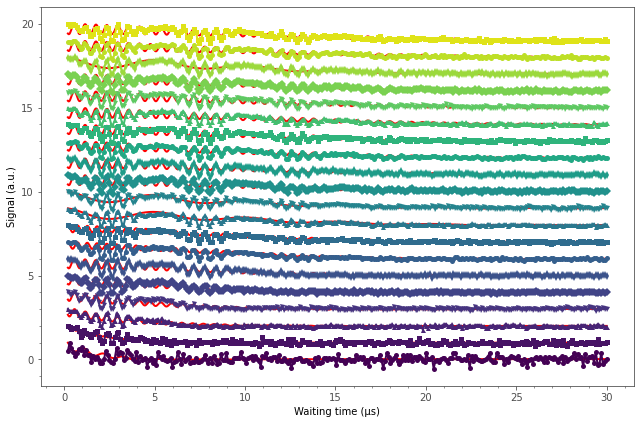

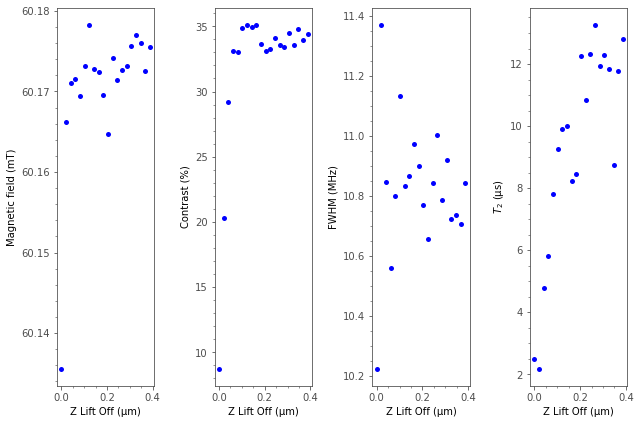

In [20]:
import matplotlib

#Analyse bias field
#Gathering data from dictonary

z_scan_array = data_array['PODMR_sig']['coord0_arr'][0:20]
freq_list = data_array['PODMR_sig']['coord2_arr']
tau_list = data_array['T2_sig']['coord2_arr']
res_freq = data_array['res_freq']['data'][0:20]
T2_data = data_array['T2_sig']['data'][0:20]
PODMR_data = data_array['PODMR_sig']['data'][0:20]
t2s = np.zeros(len(T2_data))
contrast = np.zeros(len(PODMR_data))
fwhm = np.zeros(len(PODMR_data))

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

gslac = False
left = False

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv

fwhm_bias = 0
contrast_bias = 0

fig = plt.figure()
# ax_HE = fig.add_subplot(projection='3d')
ax_HE = fig.add_subplot()

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(T2_data))

for idx, data in enumerate(PODMR_data):
    fit = afm_scanner_logic._fitlogic.make_gaussian_fit(freq_list,data,estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
    fwhm[idx] = fit.params['fwhm'].value*1e-6 #FWHM in MHz
    contrast[idx] = fit.params['contrast'].value*-1

for idx, data in enumerate(T2_data):
    
    rgba = cmap(norm(idx))
    fit = afm_scanner_logic._fitlogic.make_sinedoublewithexpdecay_fit(tau_list,data,estimator=afm_scanner_logic._fitlogic.estimate_sinedoublewithexpdecay)
    t2s[idx] = fit.params['lifetime']
    lm,_ = fitlogic.make_sinedoublewithexpdecay_model()
    tau_list_more = np.linspace(tau_list[0],tau_list[-1],1000)
    temp = lm.eval(fit.params, x=tau_list_more)
    ax_HE.plot(tau_list_more*1e6, temp/np.max(temp)+1*idx,'r-')
    ax_HE.plot(tau_list*1e6,data/np.max(data)+1*idx, color = rgba)
    
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
ax_HE.set_xlabel('Waiting time (µs)')
ax_HE.set_ylabel('Signal (a.u.)')

plt.tight_layout()

plt.show()


fig = plt.figure()
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
ax_field = fig.add_subplot(1,4,1)
ax_contrast = fig.add_subplot(1,4,2)
ax_fwhm = fig.add_subplot(1,4,3)
ax_T2 = fig.add_subplot(1,4,4)

ax_field.plot(z_scan_array*1e6, b_field_bias*1e3,'bo')
ax_contrast.plot(z_scan_array*1e6, contrast,'bo')
ax_fwhm.plot(z_scan_array*1e6, fwhm,'bo')
ax_T2.plot(z_scan_array*1e6, t2s*1e6,'bo')

ax_field.set_xlabel('Z Lift Off (µm)')
ax_field.set_ylabel('Magnetic field (mT)')

ax_contrast.set_xlabel('Z Lift Off (µm)')
ax_contrast.set_ylabel('Contrast (%)')

ax_fwhm.set_xlabel('Z Lift Off (µm)')
ax_fwhm.set_ylabel('FWHM (MHz)')

ax_T2.set_xlabel('Z Lift Off (µm)')
ax_T2.set_ylabel('$T_2$ (µs)')

plt.tight_layout()

plt.show()



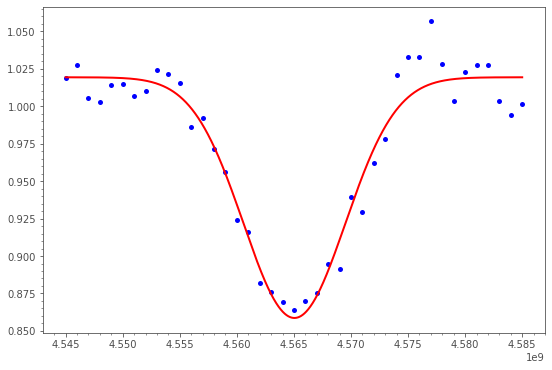

Bias field:  0.0601800990150795 T
FWHM:  10.520185209835184 MHz
Contrast:  15.762207348830518 %


In [6]:
#Analyse bias field
#Gathering data from dictonary
var_list= data_array['PODMR_sig']['coord2_arr']
data = data_array['PODMR_sig']['data'][1]

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

mode = 'gaussian_dip'
gslac = False
left = False

fwhm_bias = 0
contrast_bias = 0

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()

elif mode == 'gaussian_dip':
    fit = afm_scanner_logic._fitlogic.make_gaussian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
    lm,_ = fitlogic.make_gaussian_model()
    fwhm_bias = fit.params['fwhm'].value*1e-6 #FWHM in MHz
    contrast_bias = fit.params['contrast'].value*-1
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

# print(fit.fit_report())
bias_res_freq = fit.params['center'].value

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(bias_res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(bias_res_freq - zero_field)**2 - e_field**2) / gyro_nv

#Plot Data an
plt.plot(var_list,data,'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()

print('Bias field: ',b_field_bias,'T')
print("FWHM: ",fwhm_bias,'MHz')
print("Contrast: ",contrast_bias,'%')

In [9]:
res_freq = data_array['res_freq']['data']

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

gslac = False
left = False

if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv
    
stray_field = b_field-b_field_bias

scan_array_x = data_array['res_freq']['coord0_arr']
scan_array_y = data_array['res_freq']['coord1_arr']
scan_start_x = scan_array_x[0]
scan_stop_x = scan_array_x[-1]
scan_start_y = scan_array_y[0]
scan_stop_y = scan_array_y[-1]

# data_array.update({'b_field': {'data': b_field}})
# data_array['b_field']['coord0_arr'] = scan_array_x
# data_array['b_field']['coord1_arr'] = scan_array_y
# data_array['b_field']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
# data_array['b_field']['xy_units'] = 'm'
# data_array['b_field']['si_units'] = 'T'
# data_array['b_field']['nice_name'] = 'Sensed Field: B_NV'

data_array.update({'stray_field': {'data': stray_field}})
data_array['stray_field']['coord0_arr'] = scan_array_x
data_array['stray_field']['coord1_arr'] = scan_array_y
data_array['stray_field']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
data_array['stray_field']['xy_units'] = 'm'
data_array['stray_field']['si_units'] = 'T'
data_array['stray_field']['nice_name'] = 'Stray Field: B_NV - B_bias'

with open(filepath+'_jupyter_corrected.pickle', 'wb') as f:
    pickle.dump(data_array, f)
    
save_obj_to_gwyddion(dataobj=data_array,filename=filepath+'_jupyter_corrected.gwy')